In [1]:
import pandas as pd
import numpy as np
import warnings
from chinese_calendar import is_holiday,is_workday
import gc
import xgboost as xgb
warnings.filterwarnings('ignore')

In [3]:
#数据预处理
def prepare(dataset):
    data = dataset.copy()
    data['is_manjian'] = data['Discount_rate'].map(lambda x: 1 if ':' in str(x) else 0)
    data['discount_rate'] = data['Discount_rate'].map(lambda x: float(x) if ':' not in str(x) else (float(str(x).split(':')[0])-float(str(x).split(':')[1]))/float(str(x).split(':')[0]))
    data['min_cost_of_manjian'] = data['Discount_rate'].map(lambda x: 1 if ':' not in str(x) else int(str(x).split(':')[0]))
    data['date_received'] = pd.to_datetime(data['Date_received'], format='%Y%m%d')
    data['Distance'].fillna(-1,inplace=True)
    data['null_distance'] = data['Distance'].map(lambda x: 1 if x==-1 else 0)
    if 'Date' in data.columns.tolist():  # off_train
        data['date'] = pd.to_datetime(data['Date'], format='%Y%m%d')

    return data

def prepare_online(dataset):
    data = dataset.copy()
    data['is_manjian'] = data['Discount_rate'].map(lambda x: 1 if ':' in str(x) else 0)
    data['is_fixed'] = data['Discount_rate'].map(lambda x: 1 if 'f' in str(x) else 0)
    data['min_cost_of_manjian'] = data['Discount_rate'].map(lambda x: 1 if ':' not in str(x) else int(str(x).split(':')[0]))
    data['date_received'] = pd.to_datetime(data['Date_received'], format='%Y%m%d')
    data['date'] = pd.to_datetime(data['Date'], format='%Y%m%d')

    return data



In [4]:
#打标
def get_label(dataset):
    data = dataset.copy()
    data['label'] =  list(map(lambda x,y: 1 if (x-y).total_seconds()/(60*60*24) <= 15 else 0, data['date'],data['date_received']))

    return data

In [5]:
def is_holiday_plus(x):#判断是否为法定节假日
    try:
        # 将整数转换为 datetime.date 对象，例如 20250331 -> 2025-03-31
        return 1 if is_holiday(x) else 0
    except (NotImplementedError):  # 处理无法转换的日期
        return -1

In [6]:
class FeatureExtractor:
    def __init__(self, label_field, middle_field, history_field, online_train):
        """ 初始化时传入数据 """
        self.label_field = label_field
        self.history_field = history_field
        self.online_train = online_train
        self.features = label_field.copy()  # 目标特征集合

    def extract_label_features(self):
        """ 提取标签区间特征 """
        data = self.label_field.copy()
        data['Coupon_id'] = data['Coupon_id'].fillna(-1).astype(int)
        data['Date_received'] = data['Date_received'].fillna(-1).astype(int)
        if 'Date' in data.columns:
            data['Date'] = data['Date'].fillna(-1).astype(int)

        data['cnt'] = 1
        self.features['Coupon_id'] = self.features['Coupon_id'].fillna(-1).astype(int)

        # 用户领券数
        keys = ['User_id']  # 主键
        prefixs = 'label_' + '_'.join(keys) + '_'  # 特征名前缀,由label_field和主键组成
        pivot = pd.pivot_table(data, index=keys, values='cnt', aggfunc=len)  # 以keys为键,'cnt'为值,使用len统计出现的次数
        pivot.fillna(0, inplace=True)
        pivot = pd.DataFrame(pivot).rename(columns={
            'cnt': prefixs + 'receive_cnt'}).reset_index()  # pivot_table后keys会成为index,统计出的特征列会以values即'cnt'命名,将其改名为特征名前缀+特征意义,并将index还原
        self.features = pd.merge(self.features, pivot, on=keys, how='left')  # 将id列与特征列左连

        # 用户领取特定优惠券数
        keys = ['User_id', 'Coupon_id']  # 主键
        prefixs = 'label_' + '_'.join(keys) + '_'  # 特征名前缀,由label_field和主键组成
        pivot = pd.pivot_table(data, index=keys, values='cnt', aggfunc=len)  # 以keys为键,'cnt'为值,使用len统计出现的次数
        pivot.fillna(0, inplace=True)
        pivot = pd.DataFrame(pivot).rename(columns={
            'cnt': prefixs + 'receive_cnt'}).reset_index()  # pivot_table后keys会成为index,统计出的特征列会以values即'cnt'命名,将其改名为特征名前缀+特征意义,并将index还原
        self.features = pd.merge(self.features, pivot, on=keys, how='left')  # 将id列与特征列左连

        # 用户当天领券数
        keys = ['User_id', 'Date_received']  # 主键
        prefixs = 'label_' + '_'.join(keys) + '_'  # 特征名前缀,由label_field和主键组成
        pivot = pd.pivot_table(data, index=keys, values='cnt', aggfunc=len)  # 以keys为键,'cnt'为值,使用len统计出现的次数
        pivot.fillna(0, inplace=True)
        pivot = pd.DataFrame(pivot).rename(columns={
            'cnt': prefixs + 'receive_cnt'}).reset_index()  # pivot_table后keys会成为index,统计出的特征列会以values即'cnt'命名,将其改名为特征名前缀+特征意义,并将index还原
        self.features = pd.merge(self.features, pivot, on=keys, how='left')  # 将id列与特征列左连

        # 用户当天领取特定优惠券数
        keys = ['User_id', 'Coupon_id', 'Date_received']  # 主键
        prefixs = 'label_' + '_'.join(keys) + '_'  # 特征名前缀,由label_field和主键组成
        pivot = pd.pivot_table(data, index=keys, values='cnt', aggfunc=len)  # 以keys为键,'cnt'为值,使用len统计出现的次数
        pivot.fillna(0, inplace=True)
        pivot = pd.DataFrame(pivot).rename(columns={
            'cnt': prefixs + 'receive_cnt'}).reset_index()  # pivot_table后keys会成为index,统计出的特征列会以values即'cnt'命名,将其改名为特征名前缀+特征意义,并将index还原
        self.features = pd.merge(self.features, pivot, on=keys, how='left')  # 将id列与特征列左连

        #用户是否重复领券
        keys = ['User_id', 'Coupon_id']
        prefixs = 'label_' + '_'.join(keys) + '_'
        pivot = pd.pivot_table(data, index=keys, values='cnt', aggfunc=lambda x: 1 if len(x) > 1 else 0)
        pivot = pd.DataFrame(pivot).rename(columns={'cnt' : prefixs + 'receive_cnt'}).reset_index()
        self.features = pd.merge(self.features, pivot, on=keys, how='left')

        # 用户是否在同一天重复领取了特定优惠券
        keys = ['User_id', 'Coupon_id', 'Date_received']  # 主键
        prefixs = 'label_' + '_'.join(keys) + '_'  # 特征名前缀,由label_field和主键组成
        pivot = pd.pivot_table(data, index=keys, values='cnt',
                               aggfunc=lambda x: 1 if len(x) > 1 else 0)  # 以keys为键,'cnt'为值,判断领取次数是否大于1
        pivot = pd.DataFrame(pivot).rename(columns={
            'cnt': prefixs + 'repeat_receive_same_day'}).reset_index()
        self.features = pd.merge(self.features, pivot, on=keys, how='left')

        # 最近一次领券据考察日的时间间隔 和 最远一次领券据考察日的时间间隔
        keys = ['User_id']
        needColumns = keys.copy()
        needColumns.append('date_received')
        testDay = np.max(data.date_received)

        timedelta = data[needColumns]
        timedelta[prefixs + 'nearestReceiveToTestDay_timedelta'] = (testDay - timedelta.date_received).map(lambda x : x.total_seconds() / (60 * 60 * 24))
        timedelta.sort_values('date_received',ascending = False,inplace = True) #按领券日期降序排列
        timedelta.drop_duplicates(keys,keep = 'first',inplace = True) #按keys去重,保留第一个
        timedelta.drop(['date_received'],axis = 1,inplace = True)
        self.features = pd.merge(self.features,timedelta,on = keys,how = 'left')
        self.features[prefixs + 'nearestReceiveToTestDay_timedelta'].fillna(-1,downcast = 'infer',inplace = True) #填充缺失值-1表示没领券

        # 最远一次领券据考察日的时间间隔
        timedelta = data[needColumns]
        timedelta[prefixs + 'furthestReceiveToTestDay_timedelta'] = (testDay - timedelta.date_received).map(lambda x : x.total_seconds() / (60 * 60 * 24))
        timedelta.sort_values('date_received',ascending = True,inplace = True) #按领券日期升序排列
        timedelta.drop_duplicates(keys,keep = 'first',inplace = True) #按keys去重,保留第一个
        timedelta.drop(['date_received'],axis = 1,inplace = True)
        self.features = pd.merge(self.features,timedelta,on = keys,how = 'left')

        # 是否第一次领券
        testDay = np.max(self.features.date_received)
        isFirstReceive = list(map(lambda x,y : 1 if ((testDay - x).total_seconds() / (60 * 60 * 24)) == y else 0,self.features['date_received'],self.features[prefixs + 'furthestReceiveToTestDay_timedelta']))
        self.features[prefixs + 'isFirstReceive'] = isFirstReceive
        # 是否最后一次领券
        isLastReceive = list(map(lambda x,y : 1 if ((testDay - x).total_seconds() / (60 * 60 * 24)) == y else 0,self.features['date_received'],self.features[prefixs + 'nearestReceiveToTestDay_timedelta']))
        self.features[prefixs + 'isLastReceive'] = isLastReceive

        #用户-商户
        # 最近一次领券据考察日的时间间隔
        keys = ['User_id', 'Coupon_id']
        prefixs = 'label_' + '_'.join(keys) + '_'
        needColumns = keys.copy()
        needColumns.append('date_received')
        testDay = np.max(data.date_received)

        timedelta = data[needColumns]
        timedelta[prefixs + 'nearestReceiveToTestDay_timedelta'] = (testDay - timedelta.date_received).map(lambda x : x.total_seconds() / (60 * 60 * 24))
        timedelta.sort_values('date_received',ascending = False,inplace = True) #按领券日期降序排列
        timedelta.drop_duplicates(keys,keep = 'first',inplace = True) #按keys去重,保留第一个
        timedelta.drop(['date_received'],axis = 1,inplace = True)
        self.features = pd.merge(self.features,timedelta,on = keys,how = 'left')
        self.features[prefixs + 'nearestReceiveToTestDay_timedelta'].fillna(-1,downcast = 'infer',inplace = True) #填充缺失值-1表示没领券

        # 最远一次领券据考察日的时间间隔
        timedelta = data[needColumns]
        timedelta[prefixs + 'furthestReceiveToTestDay_timedelta'] = (testDay - timedelta.date_received).map(lambda x : x.total_seconds() / (60 * 60 * 24))
        timedelta.sort_values('date_received',ascending = True,inplace = True) #按领券日期升序排列
        timedelta.drop_duplicates(keys,keep = 'first',inplace = True) #按keys去重,保留第一个
        timedelta.drop(['date_received'],axis = 1,inplace = True)
        self.features = pd.merge(self.features,timedelta,on = keys,how = 'left')

        # 是否第一次领券
        testDay = np.max(self.features.date_received)
        isFirstReceive = list(map(lambda x,y : 1 if ((testDay - x).total_seconds() / (60 * 60 * 24)) == y else 0,self.features['date_received'],self.features[prefixs + 'furthestReceiveToTestDay_timedelta']))
        self.features[prefixs + 'isFirstReceive'] = isFirstReceive
        # 是否最后一次领券
        isLastReceive = list(map(lambda x,y : 1 if ((testDay - x).total_seconds() / (60 * 60 * 24)) == y else 0,self.features['date_received'],self.features[prefixs + 'nearestReceiveToTestDay_timedelta']))
        self.features[prefixs + 'isLastReceive'] = isLastReceive

        #用户-优惠券
        keys = ['User_id', 'Merchant_id']
        prefixs = 'label_' + '_'.join(keys) + '_'
        needColumns = keys.copy()
        needColumns.append('date_received')
        testDay = np.max(data.date_received)

        timedelta = data[needColumns]
        timedelta[prefixs + 'nearestReceiveToTestDay_timedelta'] = (testDay - timedelta.date_received).map(lambda x : x.total_seconds() / (60 * 60 * 24))
        timedelta.sort_values('date_received',ascending = False,inplace = True) #按领券日期降序排列
        timedelta.drop_duplicates(keys,keep = 'first',inplace = True) #按keys去重,保留第一个
        timedelta.drop(['date_received'],axis = 1,inplace = True)
        self.features = pd.merge(self.features,timedelta,on = keys,how = 'left')
        self.features[prefixs + 'nearestReceiveToTestDay_timedelta'].fillna(-1,downcast = 'infer',inplace = True) #填充缺失值-1表示没领券

        # 最远一次领券据考察日的时间间隔
        timedelta = data[needColumns]
        timedelta[prefixs + 'furthestReceiveToTestDay_timedelta'] = (testDay - timedelta.date_received).map(lambda x : x.total_seconds() / (60 * 60 * 24))
        timedelta.sort_values('date_received',ascending = True,inplace = True) #按领券日期升序排列
        timedelta.drop_duplicates(keys,keep = 'first',inplace = True) #按keys去重,保留第一个
        timedelta.drop(['date_received'],axis = 1,inplace = True)
        self.features = pd.merge(self.features,timedelta,on = keys,how = 'left')

        # 是否第一次领券
        testDay = np.max(self.features.date_received)
        isFirstReceive = list(map(lambda x,y : 1 if ((testDay - x).total_seconds() / (60 * 60 * 24)) == y else 0,self.features['date_received'],self.features[prefixs + 'furthestReceiveToTestDay_timedelta']))
        self.features[prefixs + 'isFirstReceive'] = isFirstReceive
        # 是否最后一次领券
        isLastReceive = list(map(lambda x,y : 1 if ((testDay - x).total_seconds() / (60 * 60 * 24)) == y else 0,self.features['date_received'],self.features[prefixs + 'nearestReceiveToTestDay_timedelta']))
        self.features[prefixs + 'isLastReceive'] = isLastReceive

        #用户在考察日之前/后领取的优惠券数量
        # 计算每个用户在每个日期的领券总数
        # receive_counts = pd.pivot_table(
        #     data,
        #     index=['User_id', 'date_received'],
        #     values='cnt',
        #     aggfunc='sum'
        # ).reset_index().rename(columns={'cnt': 'daily_receive_count'})
        #
        # # 按 User_id 分组，计算累计领券数
        # receive_counts = receive_counts.sort_values('date_received')
        # receive_counts['cumsum_before'] = receive_counts.groupby('User_id')['daily_receive_count'].cumsum().shift(1, fill_value=0)
        # receive_counts['total_receive'] = receive_counts.groupby('User_id')['daily_receive_count'].transform('sum')
        # receive_counts['cumsum_after'] = receive_counts['total_receive'] - receive_counts['cumsum_before'] - receive_counts['daily_receive_count']
        #
        # # 提取“之前”和“之后”的领券数量
        # before_counts = receive_counts[['User_id', 'date_received', 'cumsum_before']].rename(
        #     columns={'cumsum_before': prefixs + 'before_receive_cnt'}
        # )
        # after_counts = receive_counts[['User_id', 'date_received', 'cumsum_after']].rename(
        #     columns={'cumsum_after': prefixs + 'after_receive_cnt'}
        # )
        #
        # # 合并到 self.features
        # self.features = pd.merge(self.features, before_counts, on=['User_id', 'date_received'], how='left')
        # self.features = pd.merge(self.features, after_counts, on=['User_id', 'date_received'], how='left')
        # # 填充缺失值
        # self.features[prefixs + 'before_receive_cnt'] = self.features[prefixs + 'before_receive_cnt'].fillna(0).astype(int)
        # self.features[prefixs + 'after_receive_cnt'] = self.features[prefixs + 'after_receive_cnt'].fillna(0).astype(int)

        #用户领取了多少种优惠券
        keys = ['User_id']
        pivot = pd.pivot_table(data[data['Date_received'].notna()], index=keys, values='Coupon_id', aggfunc=lambda x: len(set(x)))
        pivot.fillna(0, inplace=True)
        pivot = pd.DataFrame(pivot).rename(columns={'Coupon_id': prefixs +'_'.join(keys) + 'diff_coupon_cnt'})
        self.features = pd.merge(self.features, pivot, on=keys, how='left')

        #距离用户上一次领取的时间间隔
        # 排序
         # 创建透视表：按照 User_id 和 Date_received 排序
        # pivot = data.pivot_table(index=['User_id', 'date_received'], aggfunc='size').reset_index()
        #
        # # 计算上一次领取时间间隔
        # pivot[f"{prefixs}prev_receive_gap"] = pivot.groupby('User_id')['date_received'].shift(1)
        # pivot[f"{prefixs}prev_receive_gap"] = (pivot['date_received'] - pivot[f"{prefixs}prev_receive_gap"]).dt.days
        #
        # # 计算下一次领取时间间隔
        # pivot[f"{prefixs}next_receive_gap"] = pivot.groupby('User_id')['date_received'].shift(-1)
        # pivot[f"{prefixs}next_receive_gap"] = (pivot[f"{prefixs}next_receive_gap"] - pivot['date_received']).dt.days
        #
        # pivot.fillna(-1, inplace=True)
        # # 合并回原始数据
        # self.features = self.features.merge(
        #     pivot[['User_id', 'date_received', f"{prefixs}prev_receive_gap", f"{prefixs}next_receive_gap"]],
        #     on=['User_id', 'date_received'], how='left'
        # )

        #商户被领取了多少优惠券
        keys = ['Merchant_id']
        pivot = pd.pivot_table(data[data['Date_received'].notna()], index=keys, values='cnt', aggfunc=len)
        pivot.fillna(0, inplace=True)
        pivot = pd.DataFrame(pivot).rename(columns={'cnt': prefixs +'_'.join(keys) + 'received_cnt'})
        self.features = pd.merge(self.features, pivot, on=keys, how='left')

        #商户发行了多少种优惠券
        keys = ['Merchant_id']
        pivot = pd.pivot_table(data[data['Date_received'].notna()], index=keys, values='Coupon_id', aggfunc=lambda x: len(set(x)))
        pivot.fillna(0, inplace=True)
        pivot = pd.DataFrame(pivot).rename(columns={'Coupon_id': prefixs +'_'.join(keys) + 'diff_coupon_cnt'})
        self.features = pd.merge(self.features, pivot, on=keys, how='left')

        #上旬领券次数
        keys = ['User_id']
        pivot = pd.pivot_table(data[data['date_received'].map(lambda x: x.day >=1 and x.day <= 10)], index=keys, values='cnt', aggfunc=len)
        pivot.fillna(0, inplace=True)
        pivot = pd.DataFrame(pivot).rename(columns={'cnt': prefixs +'_'.join(keys) + 'received_cnt_f'})
        self.features = pd.merge(self.features, pivot, on=keys, how='left')

        #中旬领券次数
        pivot = pd.pivot_table(data[data['date_received'].map(lambda x: x.day >=11 and x.day <=20)], index=keys, values='cnt', aggfunc=len)
        pivot.fillna(0, inplace=True)
        pivot = pd.DataFrame(pivot).rename(columns={'cnt': prefixs +'_'.join(keys) + 'received_cnt_m'})
        self.features = pd.merge(self.features, pivot, on=keys, how='left')

        #下旬领券次数
        pivot = pd.pivot_table(data[data['date_received'].map(lambda x: x.day >=21 and x.day <=31)], index=keys, values='cnt', aggfunc=len)
        pivot.fillna(0, inplace=True)
        pivot = pd.DataFrame(pivot).rename(columns={'cnt': prefixs +'_'.join(keys) + 'received_cnt_l'})
        self.features = pd.merge(self.features, pivot, on=keys, how='left')

        #用户领取特定商家的优惠券数目
        keys = ['User_id', 'Merchant_id']
        pivot = pd.pivot_table(data, index=keys, values='cnt', aggfunc=len)
        pivot.fillna(0, inplace=True)
        pivot = pd.DataFrame(pivot).rename(columns={'cnt': prefixs +'_'.join(keys) + 'receive_cnt'}).reset_index()
        self.features = pd.merge(self.features, pivot, on=keys, how='left')

        #商家被领取的特定优惠券数目
        keys = ['Merchant_id', 'Coupon_id']
        pivot = pd.pivot_table(data, index=keys, values='cnt', aggfunc=len)
        pivot.fillna(0, inplace=True)
        pivot = pd.DataFrame(pivot).rename(columns={'cnt': prefixs +'_'.join(keys) + 'receive_cnt'}).reset_index()
        self.features = pd.merge(self.features, pivot, on=keys, how='left')

        #用户领取满减券数
        keys = ['User_id']
        pivot = pd.pivot_table(data[data['is_manjian'] == 1], index=keys, values='cnt', aggfunc=len)
        pivot.fillna(0, inplace=True)
        pivot = pd.DataFrame(pivot).rename(columns={'cnt': prefixs +'_'.join(keys) + 'receive_manjian_cnt'})
        self.features = pd.merge(self.features, pivot, on=keys, how='left')
        del data
        gc.collect()



    def extract_history_features(self):
        """ 提取历史区间特征 """
        data = self.history_field.copy()
        data['cnt'] = 1

        prefix = 'history_'
        # 用户特征

        keys = ['User_id']
        user_feature = self.label_field[keys].drop_duplicates(keep='first') #去重

        # 用户历史消费次数
        user_feature = self._add_feature(data, keys, 'consume_cnt', target=user_feature, prefix=prefix, fill=True)

        # 用户历史领券数
        user_feature = self._add_feature(data[data['Date_received'].notna()], keys, 'receive_cnt', target=user_feature, prefix=prefix, fill=True)

        #用户核销次数
        user_feature = self._add_feature(data[data['Date'].notna() & data['Coupon_id'].notna()], keys, 'receive_and_consume_cnt', target=user_feature, prefix=prefix, fill=True)

        # 用户核销率
        user_feature[prefix + '_'.join(keys) + '_' + 'received_and_consume_rate'] = user_feature[prefix + '_'.join(keys) + '_' + 'receive_and_consume_cnt'] / user_feature[prefix + '_'.join(keys) + '_' + 'receive_cnt'].replace(0, 1)

        #用户对商家券的15天内核销次数
        user_feature = self._add_feature(data[data['label'] == 1], keys, 'received_and_consume_cnt_15day', target=user_feature,prefix=prefix, value='Merchant_id',aggfunc=lambda x:len(set(x)), fill=True)

        #上旬领券次数
        user_feature  =self._add_feature(data[data['date_received'].map(lambda x: x.day >=1 and x.day <= 10)], keys, 'received_cnt_f', target=user_feature, prefix=prefix, fill=True)

        #中旬领券次数
        user_feature  =self._add_feature(data[data['date_received'].map(lambda x: x.day >=11 and x.day <= 20)], keys, 'received_cnt_m', target=user_feature, prefix=prefix ,fill=True)

        #下旬领券次数
        user_feature  =self._add_feature(data[data['date_received'].map(lambda x: x.day >=21 and x.day <= 30)], keys, 'received_cnt_l', target=user_feature, prefix=prefix, fill=True)

        #领取并使用满减券次数
        user_feature = self._add_feature(data[data['is_manjian'] == 1], keys, 'manjian_receive_and_consume_cnt', target=user_feature, prefix=prefix, fill=True)

        #领取并使用非满减券次数
        user_feature = self._add_feature(data[data['is_manjian'] == 0 & data['Date_received'].notna()], keys, 'not_manjian_receive_and_consume_cnt', target=user_feature, prefix=prefix)

        #核销优惠券的平均折扣率
        user_feature = self._add_feature(data[(data['Date'].notna() & data['Coupon_id'].notna())], keys, 'receive_and_consume_avg_discount_rate', target=user_feature,prefix=prefix, value='discount_rate', aggfunc=np.mean)

        #核销优惠券的最高折扣率
        user_feature = self._add_feature(data[(data['Date'].notna() & data['Coupon_id'].notna())], keys, 'receive_and_consume_max_discount_rate', target=user_feature, prefix=prefix, value='discount_rate', aggfunc=np.min)

        #核销优化券的最低折扣率
        user_feature = self._add_feature(data[(data['Date'].notna() & data['Coupon_id'].notna())], keys, 'receive_and_consume_min_discount_rate', target=user_feature, prefix=prefix, aggfunc=np.max)

        #核销优惠券的平均距离
        user_feature = self._add_feature(data[(data['Coupon_id'].notna() & data['Date'].notna() & data['null_distance'] == 0)], keys, 'receive_and_consume_avg_distance', target=user_feature,prefix=prefix, value='Distance', aggfunc=np.mean)

        #核销优惠券的最大距离
        user_feature = self._add_feature(data[(data['Coupon_id'].notna() & data['Date'].notna() & data['null_distance'] == 0)], keys, 'receive_and_consume_max_distance', target=user_feature,prefix=prefix, value='Distance', aggfunc=np.max)

        #核销优惠券的最小距离
        user_feature = self._add_feature(data[(data['Coupon_id'].notna() & data['Date'].notna() & data['null_distance'] == 0)], keys, 'receive_and_consume_min_distance', target=user_feature,prefix=prefix, value='Distance', aggfunc=np.min)

        #在多少不同商家领取并消费优惠券
        user_feature = self._add_feature(data[(data['Coupon_id'].notna() & data['Date'].notna())], keys, 'diff_merchant_receive_and_consume_cnt', target=user_feature,prefix=prefix, value='Merchant_id',aggfunc=lambda x:len(set(x)))

        # #在多少不同商家领取优惠券
        # user_feature = self._add_feature(data, keys, 'diff_merchant_receive_cnt', target=user_feature,prefix=prefix, value='Merchant_id',aggfunc=lambda x:len(set(x)))
        #
        # #在多少不同商家领取并消费优惠券 / 在多少不同商家领取优惠券
        # user_feature[prefix + 'diff_merchant_receive_and_consume_cnt_and not_rate'] = user_feature[prefix + '_'.join(keys) + '_' + 'diff_merchant_receive_and_consume_cnt']/user_feature[prefix + '_'.join(keys) + '_' + 'diff_merchant_receive_cnt'].replace(0, 1)

        # # 满0-50减的核销率
        # user_feature = self._add_feature(
        #     data[(data['Date'].notna()) & (data['min_cost_of_manjian'] <= 50)],
        #     keys,
        #     feature_name='receive_and_consume_rate_0_50',
        #     target=user_feature,
        #     prefix=prefix,
        #     aggfunc=len
        # )
        # user_feature[prefix + '_'.join(keys) + '_'+'receive_and_consume_rate_0_50'] = (
        #     user_feature[prefix + '_'.join(keys) + '_'+'receive_and_consume_rate_0_50'] /
        #     user_feature[prefix + '_'.join(keys) + '_'+'receive_cnt'].replace(0, 1)
        # )
        # # 处理 50-200区间
        # user_feature = self._add_feature(
        #     data[(data['Date'].notna() & (data['min_cost_of_manjian'] > 50) & (data['min_cost_of_manjian'] <= 200))],
        #     keys,
        #     feature_name='receive_and_consume_rate_50_200',
        #     target=user_feature,
        #     prefix=prefix,
        #     aggfunc=len
        # )
        # user_feature[prefix + '_'.join(keys) + '_'+'receive_and_consume_rate_50_200'] = (
        #     user_feature[prefix + '_'.join(keys) + '_'+'receive_and_consume_rate_50_200'] /
        #     user_feature[prefix + '_'.join(keys) + '_'+'receive_cnt'].replace(0, 1)
        # )
        #
        # # 满200-500减的核销占比
        # user_feature = self._add_feature(
        #     data[((data['Date'].notna()) & (data['min_cost_of_manjian'] > 200))],
        #     keys,
        #     feature_name='receive_and_consume_rate_200_500',
        #     target=user_feature,
        #     prefix=prefix,
        #     aggfunc=len
        # )
        # user_feature[prefix + '_'.join(keys) + '_'+'receive_and_consume_rate_200_500'] = (
        #     user_feature[prefix + '_'.join(keys) + '_'+'receive_and_consume_rate_200_500'] /
        #     user_feature[prefix + '_'.join(keys) + '_'+'receive_cnt'].replace(0, 1)
        # )

        #整合
        self.features = self.features.merge(user_feature, on=keys, how='left')
        del user_feature
        gc.collect()
        #商户特征

        keys = ['Merchant_id']
        merchant_feature = self.label_field[keys].drop_duplicates(keep='first')

        # 总优惠销售次数
        merchant_feature = self._add_feature(data[data['Date'].notna()], keys, 'total_consume_cnt', target=merchant_feature, prefix=prefix)


        #商家优惠券被领取次数
        merchant_feature = self._add_feature(data, keys, 'received_cnt', target=merchant_feature, prefix=prefix)

        #商家被哪些不同客户领取
        merchant_feature = self._add_feature(data, keys, 'received+diff_user_cnt', target=merchant_feature, prefix=prefix, value='User_id', aggfunc=lambda x:len(set(x)))

        #商家的券被核销的次数
        merchant_feature = self._add_feature(data[data['Date'].notna()], keys,'received_and_consumed_cnt', target=merchant_feature,prefix=prefix)

        #商家的券被核销率
        # merchant_feature[f'{prefix}received_and_consumed_rate'] = merchant_feature[prefix + '_'.join(keys) + '_' + 'received_and_consumed_cnt']/merchant_feature[prefix + '_'.join(keys) + '_' + 'received_cnt'].replace(0, 1)

        #商家的券没被核销的次数
        # merchant_feature = self._add_feature(data[data['Date'].isna()], keys, 'receive_not_consumed_cnt', target=merchant_feature, prefix=prefix)

        #商家核销与未核销数之比
        # merchant_feature[prefix + 'received_consume and not rate'] = merchant_feature[prefix + '_'.join(keys) + '_' + 'received_and_consumed_cnt']/merchant_feature[prefix + '_'.join(keys) + '_' + 'receive_not_consumed_cnt']

        #商家提供的不同优惠券种数
        merchant_feature = self._add_feature(data, keys, 'diff_coupon_cnt', target=merchant_feature, prefix=prefix, value='Coupon_id', aggfunc=lambda x:len(set(x)))

        #发放满减券次数
        merchant_feature = self._add_feature(data[data['is_manjian'] == 1], keys, 'manjian_received_cnt', target=merchant_feature, prefix=prefix)

        #领取非满减券次数
        merchant_feature = self._add_feature(data[data['is_manjian'] == 0], keys, 'not_manjian_received_cnt', target=merchant_feature, prefix=prefix)

        #优惠券的平均折扣率
        merchant_feature = self._add_feature(data, keys, 'receive_and_consume_avg_discount_rate', target=merchant_feature,prefix=prefix, value='discount_rate', aggfunc=np.mean)

        #优惠券的最高折扣率
        merchant_feature = self._add_feature(data[data['Date'].notna()], keys, 'receive_and_consume_max_discount_rate', target=merchant_feature, prefix=prefix, value='discount_rate', aggfunc=np.min)

        #优惠券的最低折扣率
        merchant_feature = self._add_feature(data[data['Date'].notna()], keys, 'receive_and_consume_min_discount_rate', target=merchant_feature, prefix=prefix, aggfunc=np.max)

        #消费的平均距离
        merchant_feature = self._add_feature(data[data['Date'].notna() & data['null_distance'] == 0], keys, 'receive_and_consume_avg_distance', target=merchant_feature,prefix=prefix, value='Distance', aggfunc=np.mean)

        #核销优惠券的最大距离
        merchant_feature = self._add_feature(data[data['Date'].notna() & data['null_distance'] == 0], keys, 'receive_and_consume_max_distance', target=merchant_feature,prefix=prefix, value='Distance', aggfunc=np.max)

        #核销优惠券的最小距离
        merchant_feature = self._add_feature(data[data['Date'].notna() & data['null_distance'] == 0], keys, 'receive_and_consume_min_distance', target=merchant_feature,prefix=prefix, value='Distance', aggfunc=np.min)

        #整合
        self.features = self.features.merge(merchant_feature, on=keys, how='left')
        del merchant_feature
        gc.collect()
        #优惠券特征
        keys = ['Coupon_id']
        coupon_feature = self.label_field[keys].drop_duplicates(keep='first')

        #优惠券被领取的次数
        coupon_feature = self._add_feature(data, keys, 'received_cnt', target=coupon_feature, prefix=prefix)

        #优惠券15天内被核销的次数
        coupon_feature = self._add_feature(data[data['label'] == 1], keys, 'received_and_consumed_cnt_15day', target=coupon_feature, prefix=prefix)

        #优惠券15天内的被核销率
        coupon_feature[prefix + '_'.join(keys) + '_' + 'received_and_consumed_rate_15day'] = coupon_feature[prefix + '_'.join(keys) + '_' + 'received_and_consumed_cnt_15day']/coupon_feature[prefix + '_'.join(keys) + '_' + 'received_cnt'].replace(0, 1)

        #15天内被核销的平均时间间隔
        tmp = data[data['label'] == 1]
        tmp['gap'] = (tmp['date']-tmp['date_received']).map(lambda x: x.total_seconds()/60*60*24)
        coupon_feature = self._add_feature(tmp, keys, 'consumed_mean_gap_15day', target=coupon_feature, prefix=prefix, value='gap',aggfunc=np.mean)

        #满减最低消费中位数
        coupon_feature = self._add_feature(data[data['is_manjian'] == 1], keys, 'median_min_cost_of_manjian', target=coupon_feature, prefix=prefix, value='is_manjian',aggfunc=np.median)

        #领取满减券次数
        coupon_feature = self._add_feature(data[data['is_manjian'] == 1], keys, 'manjian_received_cnt', target=coupon_feature, prefix=prefix)

        #领取非满减券次数
        coupon_feature = self._add_feature(data[data['is_manjian'] == 0 & data['Date_received'].notna()], keys, 'not_manjian_received_cnt', target=coupon_feature, prefix=prefix)

        #核销优惠券的平均折扣率
        coupon_feature = self._add_feature(data[data['Date'].notna()], keys, 'receive_and_consume_avg_discount_rate', target=coupon_feature,prefix=prefix, value='discount_rate', aggfunc=np.mean)

        #核销优惠券的平均距离
        coupon_feature = self._add_feature(data[data['Date'].notna() & data['null_distance'] == 0], keys, 'receive_and_consume_avg_distance', target=coupon_feature,prefix=prefix, value='Distance', aggfunc=np.mean)

        #整合
        self.features = self.features.merge(coupon_feature, on=keys, how='left')
        del coupon_feature
        gc.collect()
        #用户-优惠券特征
        keys = ['User_id', 'Coupon_id']
        user_coupon_feature = self.history_field[keys].drop_duplicates(keep='first')

        #用户领取该种优惠券数量
        user_coupon_feature = self._add_feature(data, keys, 'receive_cnt',target=user_coupon_feature ,prefix=prefix)

        #用户核销该商户优惠券的数量
        user_coupon_feature = self._add_feature(data[data['Date'].notna()], keys, 'receive_and_consume_cnt', target=user_coupon_feature, prefix=prefix)

         #核销优惠券的平均折扣率
        user_coupon_feature = self._add_feature(data[(data['Date'].notna() & data['Coupon_id'].notna())], keys, 'receive_and_consume_avg_discount_rate', target=user_coupon_feature,prefix=prefix, value='discount_rate', aggfunc=np.mean)

        #核销优惠券的最高折扣率
        user_coupon_feature = self._add_feature(data[(data['Date'].notna() & data['Coupon_id'].notna())], keys, 'receive_and_consume_max_discount_rate', target=user_coupon_feature, prefix=prefix, value='discount_rate', aggfunc=np.min)

        #核销优化券的最低折扣率
        user_coupon_feature = self._add_feature(data[(data['Date'].notna() & data['Coupon_id'].notna())], keys, 'receive_and_consume_min_discount_rate', target=user_coupon_feature, prefix=prefix, aggfunc=np.max)

        #核销优惠券的平均距离
        user_coupon_feature = self._add_feature(data[(data['Coupon_id'].notna() & data['Date'].notna() & data['null_distance'] == 0)], keys, 'receive_and_consume_avg_distance', target=user_coupon_feature,prefix=prefix, value='Distance', aggfunc=np.mean)

        #核销优惠券的最大距离
        user_coupon_feature = self._add_feature(data[(data['Coupon_id'].notna() & data['Date'].notna() & data['null_distance'] == 0)], keys, 'receive_and_consume_max_distance', target=user_coupon_feature,prefix=prefix, value='Distance', aggfunc=np.max)

        #核销优惠券的最小距离
        user_coupon_feature = self._add_feature(data[(data['Coupon_id'].notna() & data['Date'].notna() & data['null_distance'] == 0)], keys, 'receive_and_consume_avg_distance', target=user_coupon_feature,prefix=prefix, value='Distance', aggfunc=np.min)

        self.features = self.features.merge(user_coupon_feature, on=keys, how='left')
        del user_coupon_feature
        gc.collect()


        #商家-优惠券特征
        keys = ['Merchant_id', 'Coupon_id']
        merchant_coupon_feature = self.history_field[keys].drop_duplicates(keep='first')

        #优惠券被领取的次数
        merchant_coupon_feature = self._add_feature(data, keys, 'received_cnt', target=merchant_coupon_feature, prefix=prefix)

        #被核销多少张

        #平均被核销多少张
        merchant_coupon_feature  = self._add_feature(data[data['Date'].notna()], keys, 'received_and_consume_avg_cnt', target=merchant_coupon_feature, prefix=prefix, aggfunc=np.mean)

        #优惠券15天内被核销的次数
        merchant_coupon_feature = self._add_feature(data[data['label'] == 1], keys, 'received_and_consumed_cnt_15day', target=merchant_coupon_feature, prefix=prefix)

        #优惠券15天内的被核销率
        merchant_coupon_feature[prefix + '_'.join(keys) + '_' + 'received_and_consumed_rate_15day'] = merchant_coupon_feature[prefix + '_'.join(keys) + '_' + 'received_and_consumed_cnt_15day']/merchant_coupon_feature[prefix + '_'.join(keys) + '_' + 'received_cnt'].replace(0, 1)

        #15天内被核销的平均时间间隔
        tmp = data[data['label'] == 1]
        tmp['gap'] = (tmp['date']-tmp['date_received']).map(lambda x: x.total_seconds()/60*60*24)
        merchant_coupon_feature = self._add_feature(tmp, keys, 'consumed_mean_gap_15day', target=merchant_coupon_feature, prefix=prefix, value='gap',aggfunc=np.mean)

        #满减最低消费中位数
        merchant_coupon_feature = self._add_feature(data[data['is_manjian'] == 1], keys, 'median_min_cost_of_manjian', target=merchant_coupon_feature, prefix=prefix, value='is_manjian',aggfunc=np.median)

        #领取满减券次数
        merchant_coupon_feature = self._add_feature(data[data['is_manjian'] == 1], keys, 'manjian_received_cnt', target=merchant_coupon_feature, prefix=prefix)

        #领取非满减券次数
        merchant_coupon_feature = self._add_feature(data[data['is_manjian'] == 0 & data['Date_received'].notna()], keys, 'not_manjian_received_cnt', target=merchant_coupon_feature, prefix=prefix)

        #核销优惠券的平均折扣率
        merchant_coupon_feature = self._add_feature(data[data['Date'].notna()], keys, 'receive_and_consume_avg_discount_rate', target=merchant_coupon_feature,prefix=prefix, value='discount_rate', aggfunc=np.mean)

        #核销优惠券的平均距离
        merchant_coupon_feature = self._add_feature(data[data['Date'].notna() & data['null_distance'] == 0], keys, 'receive_and_consume_avg_distance', target=merchant_coupon_feature,prefix=prefix, value='Distance', aggfunc=np.mean)



        self.features = self.features.merge(merchant_coupon_feature, on=keys, how='left')
        del merchant_coupon_feature

        #用户-商家特征
        keys = ['User_id', 'Merchant_id']
        user_merchant_feature = self.history_field[keys].drop_duplicates(keep='first')


         # 用户历史消费次数
        user_merchant_feature = self._add_feature(data, keys, 'consume_cnt', target=user_merchant_feature,prefix=prefix)

        # 用户历史领券数
        user_merchant_feature = self._add_feature(data[data['Date_received'].notna()], keys, 'receive_cnt', target=user_merchant_feature,prefix=prefix)

        #用户核销次数
        user_merchant_feature = self._add_feature(data[data['Date'].notna() & data['Coupon_id'].notna()], keys, 'receive_and_consume_cnt', target=user_merchant_feature,prefix=prefix)

        # # 用户未核销次数
        # user_merchant_feature = self._add_feature(data[data['Date'].isna()], keys, 'receive_not_consume_cnt', target=user_merchant_feature,prefix=prefix)
        #
        # # 用户核销率
        # user_merchant_feature[prefix + '_'.join(keys) + '_' + 'received_and_consume_rate'] = user_merchant_feature[prefix + '_'.join(keys) + '_' + 'receive_and_consume_cnt'] / user_merchant_feature[prefix + '_'.join(keys) + '_' + 'receive_cnt'].replace(0, 1)
        #
        # #核销数与未核销数之比
        # user_merchant_feature[prefix + '_'.join(keys) + '_' + 'received_consume_and_not_rate'] = user_merchant_feature[prefix + '_'.join(keys) + '_' + 'receive_and_consume_cnt'] / user_merchant_feature[prefix + '_'.join(keys) + '_' + 'receive_not_consume_cnt'].replace(0, 1)
        #
        #
        # #用户对每个商家的不核销次数占商家总的不核销次数的比重
        # user_merchant_feature['history_User_id_Merchant_id_not_consume_merchant_ratio'] = (
        # user_merchant_feature['history_User_id_Merchant_id_receive_not_consume_cnt'] /
        # self.features['history_Merchant_id_receive_not_consumed_cnt'].replace(0, 1)
        # )

        self.features = self.features.merge(user_merchant_feature, on=keys, how='left')




        del data
        gc.collect()

    def extract_online_features(self):
        """提取在线特征"""
        data = self.online_train

        data['cnt'] = 1
        prefix = 'online_'

        # 用户特征
        keys = ['User_id']
        user_feature = self.label_field[keys].drop_duplicates(keep='first') #去重

        #用户在线操作次数
        user_feature = self._add_feature(data, keys, 'operated_cnt', target=user_feature, prefix=prefix)

        #用户在线领券数
        user_feature = self._add_feature(data[data['Action'] == 2] ,keys, 'received_cnt', target=user_feature, prefix=prefix)

        #用户在线购买数
        user_feature = self._add_feature(data[data['Action'] == 1] ,keys, 'consumed_cnt', target=user_feature, prefix=prefix)

        #用户在线点击数
        user_feature = self._add_feature(data[data['Action'] == 0] ,keys, 'clicked_cnt', target=user_feature, prefix=prefix)

        #用户在线不消费数
        user_feature = self._add_feature(data[data['Action'] != 1] ,keys, 'not_consumed_cnt', target=user_feature, prefix=prefix)

        #用户线上核销数
        user_feature = self._add_feature(data[data['Date_received'].notna() &data['Date'].notna()] ,keys, 'receive_and_consume_cnt', target=user_feature, prefix=prefix)

        #用户线上领取率
        user_feature[prefix + '_'.join(keys) + '_' + 'received_rate'] = user_feature[prefix + '_'.join(keys) + '_' + 'received_cnt']/user_feature[prefix + '_'.join(keys) + '_' + 'operated_cnt'].replace(0, 1)

        #用户线上购买率
        user_feature[prefix + '_'.join(keys) + '_' + 'consumed_rate'] = user_feature[prefix + '_'.join(keys) + '_' + 'consumed_cnt']/user_feature[prefix + '_'.join(keys) + '_' + 'operated_cnt'].replace(0, 1)

        #用户线上点击率
        user_feature[prefix + '_'.join(keys) + '_' + 'clicked_rate'] = user_feature[prefix + '_'.join(keys) + '_' + 'clicked_cnt']/user_feature[prefix + '_'.join(keys) + '_' + 'operated_cnt'].replace(0, 1)

        #用户线上核销率
        user_feature[prefix + '_'.join(keys) + '_' + 'receive_and_consume_rate'] = user_feature[prefix + '_'.join(keys) + '_' + 'receive_and_consume_cnt']/user_feature[prefix + '_'.join(keys) + '_' + 'received_cnt'].replace(0, 1)



        self.features = self.features.merge(user_feature, on=keys, how='left')



    def extract_date_features(self):
        """ 提取时间特征 """
        data = self.label_field.copy()

        # 计算星期几
        features = data.copy()
        features['week'] = features['date_received'].map(lambda x: x.weekday())  # 星期几
        features['is_weekend'] = features['week'].map(lambda x: 1 if x == 5 or x == 6 else 0)
        features['date_received_is_holiday'] = features['date_received'].map(lambda x: is_holiday_plus(x))  # 判断领券日是否为休息日
        features = pd.concat([features, pd.get_dummies(features['week'], prefix='week',dtype=int)], axis=1)  # one-hot离散星期几(独热编码)
        features['day_of_month'] = features['date_received'].map(lambda x: x.day) #领取优惠券是一月的第几天
        features['month'] = features['date_received'].map(lambda x: x.month)
        features.index = range(len(features))

        self.date_features = features

    def _add_feature(self, data, keys, feature_name, prefix, aggfunc=len, target=None, value='cnt', fill=False):
        """ 通用特征提取函数 """
        feature_name = prefix + '_'.join(keys) + '_' + feature_name
        pivot = pd.pivot_table(data, index=keys, values=value, aggfunc=aggfunc).reset_index()
        if(fill):
            pivot[value].fillna(0)

        pivot = pivot.rename(columns={value: feature_name})

        return target.merge(pivot, on=keys, how='left')

    def get_dataset(self):
        """ 构造数据集 """
        self.extract_label_features()
        self.extract_history_features()
        self.extract_date_features()
        self.extract_online_features()

        # #用户线下不消费次数占线上线下总的不消费次数的比重
        # self.features['offline_not_consume_ratio'] = (
        # self.features['history_User_id_receive_not_consume_cnt'] /
        # (self.features['history_User_id_receive_not_consume_cnt'] +
        # self.features['online_User_id_not_consumed_cnt']).replace(0, 1))

        #用户线下的优惠券核销次数占线上线下总的优惠券核销次数的比重
        self.features['offline_consume_ratio'] = (
        self.features['history_User_id_receive_and_consume_cnt'] /
        (self.features['history_User_id_receive_and_consume_cnt'] +
        self.features['online_User_id_receive_and_consume_cnt']).replace(0, 1))

        #用户线下领取的记录数量占总的记录数量的比重
        self.features['offline_receive_ratio'] = (
        self.features['history_User_id_receive_cnt'] /
        (self.features['history_User_id_receive_cnt'] +
        self.features['online_User_id_received_cnt']).replace(0, 1))

        date_feat = self.date_features  # 日期特征
        base_feat = self.features  # 基础特征

        # 共有属性,包括id和一些基础特征,为每个特征块的交集
        share_characters = list(set(base_feat.columns.tolist()) & set(date_feat.columns.tolist()))
        dataset = pd.concat([date_feat, base_feat.drop(share_characters, axis=1)], axis=1)
        dataset.fillna(-1, inplace=True)

        # 只有在训练集和验证集中才存在Date
        if 'Date' in dataset.columns.tolist():
            dataset.drop(['Merchant_id','Discount_rate','Date','date_received','date'], axis=1, inplace=True)  # 删除无用属性
            # label = dataset['label'].tolist()
            # dataset.drop(['label'], axis=1, inplace=True)
            # dataset['label'] = label
        else:
            dataset.drop(['Merchant_id','Discount_rate','date_received'], axis=1, inplace=True)

        dataset['User_id'] = dataset['User_id'].map(int)
        dataset['Coupon_id'] = dataset['Coupon_id'].map(int)
        dataset['Date_received'] = dataset['Date_received'].map(int)
        dataset['Distance'] = dataset['Distance'].map(int)
        if 'label' in dataset.columns.tolist():
            dataset['label'] = dataset['label'].map(int)

        return dataset



In [7]:
off_train = pd.read_csv('ccf_offline_stage1_train.csv')
off_test = pd.read_csv('ccf_offline_stage1_test_revised.csv')
online_train = pd.read_csv('ccf_online_stage1_train.csv')

online_train = prepare_online(online_train)
off_train = prepare(off_train)
off_test = prepare(off_test)
off_train = get_label(off_train)


In [8]:
# 训练集
train_history_field = off_train[off_train['date_received'].isin(pd.date_range('20160101','20160413'))] #[2016/1/1,2016/4/13)
train_middle_field = off_train[off_train['date'].isin(pd.date_range('2016/5/1',periods=15))] #[2016/5/1,2016/5/16)
train_label_field = off_train[off_train['date_received'].isin(pd.date_range('20160414','20160514'))] #[2016/4/14,2016/5/14)
#验证集
validate_history_field = off_train[off_train['date_received'].isin(pd.date_range('20160201','20160514'))] #[2016/2/1,2016/5/14)
validate_middle_field = off_train[off_train['date'].isin(pd.date_range('2016/3/16',periods=15))] #[2016/3/16,2016/3/31)
validate_label_field = off_train[off_train['date_received'].isin(pd.date_range('20160515','20160615'))] #[2016/5/15,2016/6/15)
#测试集
test_history_field = off_train[off_train['date_received'].isin(pd.date_range('20160315','20160630'))]  # [2016/3/15,2016/6/30)
test_middle_field = off_train[off_train['date'].isin(pd.date_range('2016/6/16', periods=15))]  # [20160616,20160701)
test_label_field = off_test.copy()  # [20160701,20160801)

# 划分区间
# 训练集历史区间、中间区间、标签区间
# train_history_field = off_train[
#     off_train['date_received'].isin(pd.date_range('2016/3/2', periods=60))]  # [20160302,20160501)
# train_middle_field = off_train[off_train['date'].isin(pd.date_range('2016/5/1', periods=15))]  # [20160501,20160516)
# train_label_field = off_train[
#     off_train['date_received'].isin(pd.date_range('2016/5/16', periods=31))]  # [20160516,20160616)
# # 验证集历史区间、中间区间、标签区间
# validate_history_field = off_train[
#     off_train['date_received'].isin(pd.date_range('2016/1/16', periods=60))]  # [20160116,20160316)
# validate_middle_field = off_train[
#     off_train['date'].isin(pd.date_range('2016/3/16', periods=15))]  # [20160316,20160331)
# validate_label_field = off_train[
#     off_train['date_received'].isin(pd.date_range('2016/3/31', periods=31))]  # [20160331,20160501)
# # 测试集历史区间、中间区间、标签区间
# test_history_field = off_train[
#     off_train['date_received'].isin(pd.date_range('2016/4/17', periods=60))]  # [20160417,20160616)
# test_middle_field = off_train[off_train['date'].isin(pd.date_range('2016/6/16', periods=15))]  # [20160616,20160701)
# test_label_field = off_test.copy()  # [20160701,20160801)


In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_flexible_time_windows(windows_dict):
    """
    可选中间区间的灵活时间窗口可视化（带起止标注）

    参数：
    - windows_dict: dict[str, tuple[str, str]]
      key 的格式不限（推荐使用 train_label / validate_history 等）
    """
    categories = {}
    y_labels = []
    y_map = {}
    color_palette = {
        'history': 'skyblue',
        'middle': 'orange',
        'label': 'green'
    }

    # 默认色轮，如果用户定义了新的类型
    fallback_colors = ['purple', 'brown', 'red', 'gray']
    fallback_idx = 0

    for key in windows_dict:
        parts = key.split('_')
        dataset = parts[0]  # train / validate / test
        stage = parts[1] if len(parts) > 1 else 'unknown'

        if dataset not in y_map:
            y_map[dataset] = len(y_map) + 1
            y_labels.append(dataset.capitalize())

        start = datetime.strptime(windows_dict[key][0], "%Y-%m-%d")
        end = datetime.strptime(windows_dict[key][1], "%Y-%m-%d")
        categories[key] = (start, end, y_map[dataset], stage)

    fig, ax = plt.subplots(figsize=(12, 4))

    for key, (start, end, y, stage) in categories.items():
        # 颜色分配
        color = color_palette.get(stage)
        if color is None:
            color = fallback_colors[fallback_idx % len(fallback_colors)]
            fallback_idx += 1

        # 画线段
        ax.plot([start, end], [y, y], lw=6, color=color,
                label=stage if stage not in ax.get_legend_handles_labels()[1] else "")

        # 标注起止时间
        ax.text(start, y + 0.1, start.strftime('%m-%d'), ha='right', va='bottom', fontsize=8, rotation=45, color='gray')
        ax.text(end, y + 0.1, end.strftime('%m-%d'), ha='left', va='bottom', fontsize=8, rotation=45, color='gray')

    # 设置图表属性
    ax.set_yticks(list(y_map.values()))
    ax.set_yticklabels(y_labels)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.title("Flexible Time Window Visualization")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


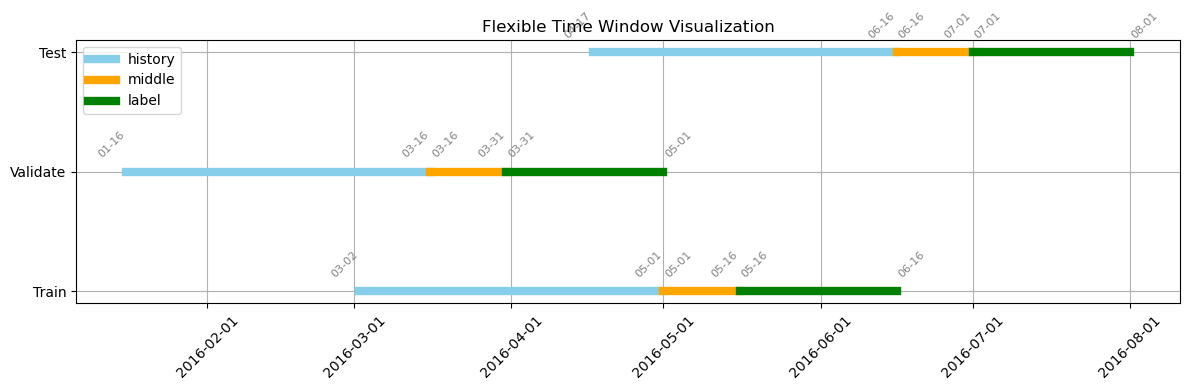

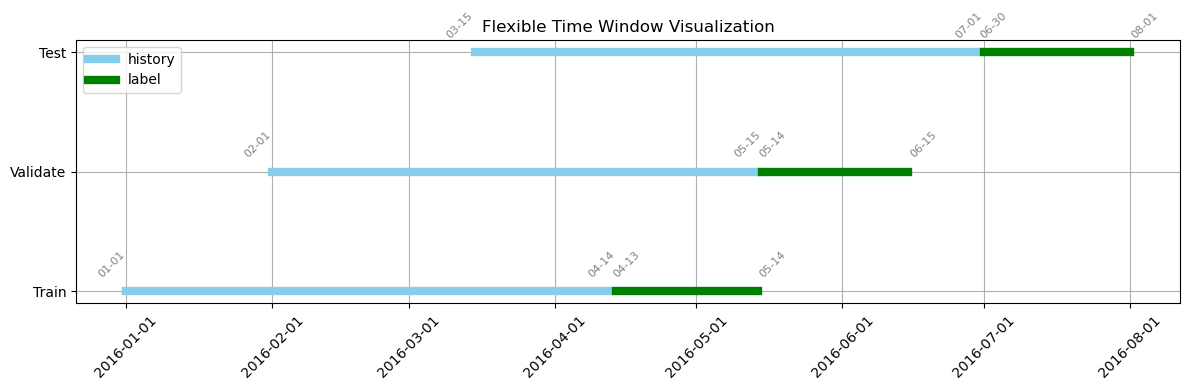

In [17]:
# 定义每个区间的起止日期
windows_fno0 = {
    'train_history': ('2016-03-02', '2016-05-01'),
    'train_middle': ('2016-05-01', '2016-05-16'),
    'train_label': ('2016-05-16', '2016-06-16'),
    'validate_history': ('2016-01-16', '2016-03-16'),
    'validate_middle': ('2016-03-16', '2016-03-31'),
    'validate_label': ('2016-03-31', '2016-05-01'),
    'test_history': ('2016-04-17', '2016-06-16'),
    'test_middle': ('2016-06-16', '2016-07-01'),
    'test_label': ('2016-07-01', '2016-08-01'),
}
windows_wepe = {
    'train_history': ('2016-01-01', '2016-04-13'),
    'train_label': ('2016-04-14', '2016-05-14'),

    'validate_history': ('2016-02-01', '2016-05-14'),
    'validate_label': ('2016-05-15', '2016-06-15'),

    'test_history': ('2016-03-15', '2016-06-30'),
    'test_label': ('2016-07-01', '2016-08-01'),
}

plot_flexible_time_windows(windows_fno0)
plot_flexible_time_windows(windows_wepe)

In [10]:
print('构造训练集')
train_exractor = FeatureExtractor(train_label_field, train_middle_field, train_history_field, online_train)
train = train_exractor.get_dataset()
print('构造验证集')
validate_exractor = FeatureExtractor(validate_label_field,validate_middle_field,validate_history_field, online_train)
validate = validate_exractor.get_dataset()
print('构造测试集')
test_exractor = FeatureExtractor(test_label_field, test_middle_field, test_history_field, online_train)
test = test_exractor.get_dataset()

构造训练集
构造验证集
构造测试集


In [11]:
def model_xgb(train, test):
    # xgb参数
    # params = {'eta': 0.010000813973175772,
    #          'max_depth': 8,
    #          'min_child_weight': 5.856993928408732,
    #          'gamma': 0.9004871175913485,
    #          'lambda': 9.7144218935128526,
    #          'alpha': 4.371906710227959,
    #          'colsample_bytree': 0.5983748787694372,
    #          'subsample': 0.5468347195196587,
    #          'scale_pos_weight': 4.527831379068361,
    #          'booster': 'gbtree',
    #          'objective': 'binary:logistic',
    #           'seed' : 16,
    #          'eval_metric': 'auc',
    #          'device': 'gpu'}
    # params = {'eta': 0.010000813973175772,
    #          'max_depth': 8,
    #          'min_child_weight': 7,
    #          'gamma': 1,
    #          'lambda': 10,
    #          'alpha': 4.371906710227959,
    #          'colsample_bytree': 0.5983748787694372,
    #          'subsample': 0.5468347195196587,
    #          'scale_pos_weight': 2.527831379068361,
    #          'booster': 'gbtree',
    #          'objective': 'binary:logistic',
    #          'seed' : 16,
    #          'eval_metric': 'auc',
    #          'device': 'gpu'}
#7978:
    # params = {'eta': 0.010000813973175772,
    #          'max_depth': 8,
    #          'min_child_weight': 7,
    #          'gamma': 1,
    #          'lambda': 12,
    #          'alpha': 4.371906710227959,
    #          'colsample_bytree': 0.5983748787694372,
    #          'subsample': 0.5468347195196587,
    #          'scale_pos_weight': 2.527831379068361,
    #          'booster': 'gbtree',
    #          'objective': 'binary:logistic',
    #          'seed' : 16,
    #          'eval_metric': 'auc',
    #          'device': 'gpu'}
    #7919
    # params = {'eta': 0.010000813973175772,
    #          'max_depth': 8,
    #          'min_child_weight': 7,
    #          'gamma': 1,
    #          'lambda': 12,
    #          'alpha': 4.371906710227959,
    #          'colsample_bytree': 0.5983748787694372,
    #          'subsample': 0.5468347195196587,
    #          'scale_pos_weight': 2.527831379068361,
    #          'booster': 'gbtree',
    #          'objective': 'binary:logistic',
    #          'seed' : 16,
    #          'eval_metric': 'auc',
    #          'device': 'gpu'}
    #8018
    params = {'eta': 0.020000813973175772,
             'max_depth': 8,
             'min_child_weight': 7,
             'gamma': 1,
             'lambda': 12,
             'alpha': 4.371906710227959,
             'colsample_bytree': 0.5983748787694372,
             'subsample': 0.5468347195196587,
             'scale_pos_weight': 2.527831379068361,
             'booster': 'gbtree',
             'objective': 'binary:logistic',
             'seed' : 16,
             'eval_metric': 'auc',
             'device': 'gpu'}


    # 数据集
    dtrain = xgb.DMatrix(train.drop(['User_id', 'Coupon_id', 'Date_received', 'label'], axis=1), label=train['label'])
    dtest = xgb.DMatrix(test.drop(['User_id', 'Coupon_id', 'Date_received'], axis=1))
    # 训练
    watchlist = [(dtrain, 'train')]
    model = xgb.train(params, dtrain, num_boost_round=1500, evals=watchlist)
    # 预测
    predict = model.predict(dtest)
    # 处理结果
    predict = pd.DataFrame(predict, columns=['prob'])
    result = pd.concat([test[['User_id', 'Coupon_id', 'Date_received']], predict], axis=1)
    # 特征重要性
    feat_importance = pd.DataFrame(columns=['feature_name', 'importance'])
    feat_importance['feature_name'] = model.get_score().keys()
    feat_importance['importance'] = model.get_score().values()
    feat_importance.sort_values(['importance'], ascending=False, inplace=True)
    # 返回
    return result, feat_importance

In [40]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def model_hgbdt(train, test):
    # HGBDT参数
    #7951
    # params = {
    #     'learning_rate': 0.05,
    #     'max_depth': 8,
    #     'max_leaf_nodes': 2**8,
    #     'min_samples_leaf': 5,
    #     'l2_regularization': 8,
    #     'max_bins': 255,
    #     'early_stopping': True,
    #     'validation_fraction': 0.2,  # 会用一部分训练数据作为验证集
    #     'n_iter_no_change': 10,
    #     'random_state': 16,
    #     'verbose': 1   # 让训练过程能输出验证集的分数
    # }
    params = {
        'learning_rate': 0.05,
        'max_depth': 10,
        'max_leaf_nodes': 2**8,
        'min_samples_leaf': 5,
        'l2_regularization': 8,
        'max_bins': 255,
        'early_stopping': True,
        'validation_fraction': 0.2,  # 会用一部分训练数据作为验证集
        'n_iter_no_change': 10,
        'random_state': 16,
        'verbose': 1   # 让训练过程能输出验证集的分数
    }


    # 特征和标签准备
    X = train.drop(['User_id', 'Coupon_id', 'Date_received', 'label'], axis=1)
    y = train['label']
    X_test = test.drop(['User_id', 'Coupon_id', 'Date_received'], axis=1)

    # 手动划分训练集、验证集（更加灵活控制）
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=16, stratify=y
    )

    # 训练
    model = HistGradientBoostingClassifier(**params)
    model.fit(X_train, y_train)

    # 验证集预测
    val_pred = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_pred)
    print(f"Validation AUC: {val_auc:.6f}")

    # 测试集预测
    predict = model.predict_proba(X_test)[:, 1]

    # 处理结果
    predict = pd.DataFrame(predict, columns=['prob'])
    result = pd.concat([test[['User_id', 'Coupon_id', 'Date_received']].reset_index(drop=True), predict], axis=1)

    # 特征重要性
    importance = permutation_importance(model, X_train, y_train, n_repeats=5, random_state=16, scoring='roc_auc')
    feat_importance = pd.DataFrame({
        'feature_name': X_train.columns,
        'importance': importance.importances_mean
    })
    feat_importance.sort_values('importance', ascending=False, inplace=True)

    # 返回
    return result, feat_importance


In [41]:
big_train = pd.concat([train, validate], axis=0)

In [42]:
result_hgbdt, feat_importance= model_hgbdt(big_train, test)

Binning 0.235 GB of training data: 0.298 s
Binning 0.059 GB of validation data: 0.022 s
Fitting gradient boosted rounds:
Fit 100 trees in 6.397 s, (25503 total leaves)
Time spent computing histograms: 3.468s
Time spent finding best splits:  0.476s
Time spent applying splits:      0.573s
Time spent predicting:           0.088s
Validation AUC: 0.901400


In [39]:
result_hgbdt.to_csv('result_hgbdt.csv', index=False, header=None)

In [17]:
result_xgb, feat_importance = model_xgb(big_train, test)

[0]	train-auc:0.87046
[1]	train-auc:0.87808
[2]	train-auc:0.88364
[3]	train-auc:0.88360
[4]	train-auc:0.88557
[5]	train-auc:0.88615
[6]	train-auc:0.88685
[7]	train-auc:0.88761
[8]	train-auc:0.88776
[9]	train-auc:0.88785
[10]	train-auc:0.88795
[11]	train-auc:0.88853
[12]	train-auc:0.88881
[13]	train-auc:0.88899
[14]	train-auc:0.88888
[15]	train-auc:0.88904
[16]	train-auc:0.88927
[17]	train-auc:0.88922
[18]	train-auc:0.88934
[19]	train-auc:0.88957
[20]	train-auc:0.88985
[21]	train-auc:0.89015
[22]	train-auc:0.89029
[23]	train-auc:0.89048
[24]	train-auc:0.89062
[25]	train-auc:0.89062
[26]	train-auc:0.89082
[27]	train-auc:0.89093
[28]	train-auc:0.89120
[29]	train-auc:0.89135
[30]	train-auc:0.89154
[31]	train-auc:0.89158
[32]	train-auc:0.89173
[33]	train-auc:0.89191
[34]	train-auc:0.89207
[35]	train-auc:0.89216
[36]	train-auc:0.89230
[37]	train-auc:0.89236
[38]	train-auc:0.89241
[39]	train-auc:0.89242
[40]	train-auc:0.89241
[41]	train-auc:0.89256
[42]	train-auc:0.89260
[43]	train-auc:0.8926

In [18]:
result_xgb.to_csv('result_xgb.csv', index=False, header=None)

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

# 假设 result_hgbdt, result_xgb, test_label_field 已经是 pandas.DataFrame 对象
# 它们分别包含指定的列：
# result_hgbdt/result_xgb: ['User_id','Coupon_id','Date_received','prob']
# test_label_field: ['User_id','Coupon_id','Date_received','Merchant_id','label']

# 1. 数据合并：以 test_label_field 为基准，合并两个模型的预测概率
df = test_label_field.copy()
df = df.merge(
    result_hgbdt.rename(columns={'prob': 'prob_hgbdt'}),
    on=['User_id', 'Coupon_id', 'Date_received'],
    how='left'
)
df = df.merge(
    result_xgb.rename(columns={'prob': 'prob_xgb'}),
    on=['User_id', 'Coupon_id', 'Date_received'],
    how='left'
)
# 此时 df 包含列：['User_id','Coupon_id','Date_received','Merchant_id','label','prob_hgbdt','prob_xgb']

# 2. 按 Merchant_id 分组计算排名和分组大小
df['rank_hgbdt'] = df.groupby('Merchant_id')['prob_hgbdt'].rank(method='dense', ascending=True)
df['rank_xgb']  = df.groupby('Merchant_id')['prob_xgb'].rank(method='dense', ascending=True)
df['group_size'] = df.groupby('Merchant_id')['User_id'].transform('count')

# 3. 归一化：对组内多条记录使用公式归一化；单条记录组直接用原始概率
df['scaled_hgbdt'] = np.where(
    df['group_size'] > 1,
    (df['rank_hgbdt'] - 1) / (df['group_size'] - 1),
    df['prob_hgbdt']
)
df['scaled_xgb'] = np.where(
    df['group_size'] > 1,
    (df['rank_xgb'] - 1) / (df['group_size'] - 1),
    df['prob_xgb']
)

# 4. 加权融合：设置权重（默认0.5），计算加权平均分数
weight = 0.3  # 可调整的权重参数
df['ensemble_score'] = weight * df['scaled_hgbdt'] + (1 - weight) * df['scaled_xgb']




In [27]:
result_fused = df[['User_id','Coupon_id', 'Date_received', 'ensemble_score']]
display(result_fused)
result_fused.to_csv('result_fused.csv', index=False, header=None)

,User_id,Coupon_id,Date_received,ensemble_score
0,4129537,9983,20160712,0.614598
1,6949378,3429,20160706,0.769177
2,2166529,6928,20160727,0.249144
3,2166529,1808,20160727,0.653790
4,6172162,6500,20160708,0.108387
...,...,...,...,...
138343,5828093,10418,20160716,0.125144
138344,6626813,7595,20160707,0.000000
138345,6626813,7590,20160712,0.823077
138346,4547069,13602,20160717,0.627583


In [16]:
import optuna

def objective(trial, train, validation):
    """Optuna 优化的目标函数"""
    #定义超参数搜索空间
    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'eta': trial.suggest_float('eta', 0.01, 0.3),  # 学习率
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # 树深度
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 0, 5),  # L2 正则化
        'alpha': trial.suggest_float('alpha', 0, 5),  # L1 正则化
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'device': 'gpu'
    }



    # 准备训练和验证数据
    dtrain = xgb.DMatrix(train.drop(['User_id', 'Coupon_id', 'Date_received', 'label'], axis=1), label=train['label'])
    dval = xgb.DMatrix(validation.drop(['User_id', 'Coupon_id', 'Date_received', 'label'], axis=1), label=validation['label'])

    # 定义评估集
    watchlist = [(dtrain, 'train'), (dval, 'eval')]

    # 使用早停训练模型
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=3500,
        evals=watchlist,
        early_stopping_rounds=20,  # 如果 20 轮没有改进则停止
        verbose_eval=False  # 抑制输出
    )

    # 获取验证集的最佳 AUC 分数
    best_auc = model.best_score  # 最佳迭代的 AUC
    return best_auc

def tune_xgb_params(train, validation, n_trials=50):
    """使用 Optuna 调优 XGBoost 参数并直接输出最佳参数"""
    # 创建一个 Optuna 研究对象以最大化 AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, train, validation), n_trials=n_trials)

    # 获取最佳参数
    best_params = study.best_params
    best_auc = study.best_value

    # 添加未调优的固定参数
    best_params.update({
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'device': 'gpu'
    })

    # 输出最佳参数和 AUC
    print("最佳超参数:", best_params)
    print("最佳 AUC:", best_auc)

    return best_params

In [17]:
tune_xgb_params(train, validate, n_trials=50)

[I 2025-04-14 21:41:47,300] A new study created in memory with name: no-name-18745309-6a86-487d-b5ac-863809f1a21c
[I 2025-04-14 21:41:48,268] Trial 0 finished with value: 0.8342191593001387 and parameters: {'eta': 0.061660108357703074, 'max_depth': 7, 'min_child_weight': 8.369284810080492, 'gamma': 4.093653245266108, 'lambda': 2.7320457777280853, 'alpha': 4.323767969065396, 'colsample_bytree': 0.5331136067555686, 'subsample': 0.5033820521507493, 'scale_pos_weight': 5.483890029011605}. Best is trial 0 with value: 0.8342191593001387.
[I 2025-04-14 21:41:49,712] Trial 1 finished with value: 0.8385512503722851 and parameters: {'eta': 0.04379497704465336, 'max_depth': 7, 'min_child_weight': 8.22602734140383, 'gamma': 4.143313220331527, 'lambda': 2.871446781794937, 'alpha': 2.48681023277829, 'colsample_bytree': 0.5356407786676862, 'subsample': 0.540216284981258, 'scale_pos_weight': 8.095084921347038}. Best is trial 1 with value: 0.8385512503722851.
[I 2025-04-14 21:41:50,467] Trial 2 finishe

最佳超参数: {'eta': 0.12006858150936854, 'max_depth': 3, 'min_child_weight': 6.912287553893762, 'gamma': 3.033536563792511, 'lambda': 4.8849860372024, 'alpha': 4.500120872623011, 'colsample_bytree': 0.7035489387004119, 'subsample': 0.6564390217210757, 'scale_pos_weight': 6.84262375897681, 'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'device': 'gpu'}
最佳 AUC: 0.8460401704613789


{'eta': 0.12006858150936854,
 'max_depth': 3,
 'min_child_weight': 6.912287553893762,
 'gamma': 3.033536563792511,
 'lambda': 4.8849860372024,
 'alpha': 4.500120872623011,
 'colsample_bytree': 0.7035489387004119,
 'subsample': 0.6564390217210757,
 'scale_pos_weight': 6.84262375897681,
 'booster': 'gbtree',
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'device': 'gpu'}

In [18]:
# def remove_unimportant_features(dataset, feat_importance, threshold):
#     """
#     Remove features from the dataset that have an importance score below the given threshold.
#
#     Parameters:
#     - dataset (pd.DataFrame): The dataset containing the features.
#     - feat_importance (pd.DataFrame): A DataFrame with columns 'feature_name' and 'importance'.
#     - threshold (float): The importance threshold below which features are removed.
#
#     Returns:
#     - pd.DataFrame: The dataset with only important features and identifier columns.
#     """
#     id_columns = ['User_id', 'Coupon_id', 'Date_received']
#     important_features = feat_importance[feat_importance['importance'] > threshold]['feature_name'].tolist()
#     columns_to_keep = id_columns + important_features
#     if 'label' in dataset.columns:
#         columns_to_keep.append('label')
#     return dataset[columns_to_keep]

In [19]:
# big_train  = remove_unimportant_features(big_train, feat_importance, 30)
# display(big_train)
# test = remove_unimportant_features(test, feat_importance, 30)

,User_id,Coupon_id,Date_received,label_User_id_Coupon_id_Date_received_Merchant_id_Coupon_idreceive_cnt,label_User_id_Coupon_id_Date_received_nearestReceiveToTestDay_timedelta,label_User_id_Coupon_id_Date_received_Merchant_idreceived_cnt,day_of_month,label_User_id_Coupon_id_Date_received_furthestReceiveToTestDay_timedelta,history_Merchant_id_receive_and_consume_avg_distance,history_Merchant_id_total_consume_cnt,...,history_Merchant_id_Coupon_id_not_manjian_received_cnt,label_User_id_Coupon_id_Date_received_repeat_receive_same_day,history_User_id_Coupon_id_receive_and_consume_max_distance,history_User_id_Coupon_id_receive_and_consume_max_discount_rate,history_Merchant_id_Coupon_id_median_min_cost_of_manjian,offline_consume_ratio,history_User_id_diff_merchant_receive_and_consume_cnt,history_User_id_Coupon_id_receive_and_consume_avg_distance_y,history_User_id_receive_and_consume_min_discount_rate,label
0,1832624,7610,20160429,22281,15.0,22281,29,15.0,2.812003,2352.0,...,-1.0,0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,0
1,163606,5054,20160421,11893,23.0,11970,21,23.0,5.773501,116.0,...,-1.0,0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,0
2,4061024,7610,20160426,22281,18.0,22281,26,18.0,2.812003,2352.0,...,-1.0,0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,0
3,106443,3732,20160429,8845,15.0,10738,29,15.0,4.577030,519.0,...,-1.0,0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,0
4,114747,5054,20160426,11893,18.0,11970,26,18.0,5.773501,116.0,...,-1.0,0,-1.0,-1.0,1.0,-1.0,3.0,-1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258441,118539,2418,20160606,29284,9.0,31350,6,9.0,1.593643,549.0,...,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
258442,2876768,2107,20160531,302,15.0,9208,31,15.0,0.731744,604.0,...,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
258443,4056416,10883,20160613,1779,2.0,1779,13,2.0,2.400000,1.0,...,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
258444,752472,1633,20160613,929,2.0,1673,13,23.0,1.846959,75.0,...,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0


In [20]:
result, feat_importance = model_xgb(big_train, test)

[0]	train-auc:0.84927
[1]	train-auc:0.86245
[2]	train-auc:0.87368
[3]	train-auc:0.87879
[4]	train-auc:0.87976
[5]	train-auc:0.88115
[6]	train-auc:0.88238
[7]	train-auc:0.88316
[8]	train-auc:0.88349
[9]	train-auc:0.88420
[10]	train-auc:0.88416
[11]	train-auc:0.88426
[12]	train-auc:0.88437
[13]	train-auc:0.88493
[14]	train-auc:0.88468
[15]	train-auc:0.88481
[16]	train-auc:0.88497
[17]	train-auc:0.88509
[18]	train-auc:0.88508
[19]	train-auc:0.88517
[20]	train-auc:0.88530
[21]	train-auc:0.88537
[22]	train-auc:0.88551
[23]	train-auc:0.88558
[24]	train-auc:0.88557
[25]	train-auc:0.88548
[26]	train-auc:0.88560
[27]	train-auc:0.88563
[28]	train-auc:0.88580
[29]	train-auc:0.88580
[30]	train-auc:0.88571
[31]	train-auc:0.88581
[32]	train-auc:0.88572
[33]	train-auc:0.88607
[34]	train-auc:0.88605
[35]	train-auc:0.88608
[36]	train-auc:0.88594
[37]	train-auc:0.88633
[38]	train-auc:0.88629
[39]	train-auc:0.88622
[40]	train-auc:0.88618
[41]	train-auc:0.88622
[42]	train-auc:0.88616
[43]	train-auc:0.8861

In [21]:
result.to_csv(r'result.csv', index=False, header=None)

In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb

def stacking_ensemble(train, test):
    # 预处理：填充缺失值为 -1
    train = train.fillna(-1)
    test = test.fillna(-1)

    # 提取特征和标签
    X = train.drop(['User_id', 'Coupon_id', 'Date_received', 'label'], axis=1)
    y = train['label']
    X_test = test.drop(['User_id', 'Coupon_id', 'Date_received'], axis=1)

    # 定义第一层模型列表
    n_folds = 5
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # 用于保存第一层模型的预测结果
    oof_preds_lgb = np.zeros(X.shape[0])
    oof_preds_xgb = np.zeros(X.shape[0])
    test_preds_lgb = np.zeros(X_test.shape[0])
    test_preds_xgb = np.zeros(X_test.shape[0])

    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        # LightGBM模型
        train_data_lgb = lgb.Dataset(X_train, label=y_train)
        params_lgb = {
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.0346518808802638,
            'max_depth': 4,
            'verbose': -1
        }
        model_lgb = lgb.train(params_lgb, train_data_lgb, num_boost_round=1000)
        oof_preds_lgb[valid_index] = model_lgb.predict(X_valid)
        test_preds_lgb += model_lgb.predict(X_test) / n_folds

        # XGBoost模型
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)
        dtest = xgb.DMatrix(X_test)
        params_xgb = {'eta': 0.010000813973175772,
             'max_depth': 8,
             'min_child_weight': 7,
             'gamma': 1,
             'lambda': 12,
             'alpha': 4.371906710227959,
             'colsample_bytree': 0.5983748787694372,
             'subsample': 0.5468347195196587,
             'scale_pos_weight': 2.527831379068361,
             'booster': 'gbtree',
             'objective': 'binary:logistic',
             'seed' : 16,
             'eval_metric': 'auc',
             'device': 'gpu'}
        model_xgb = xgb.train(params_xgb, dtrain, num_boost_round=1000)
        oof_preds_xgb[valid_index] = model_xgb.predict(dvalid)
        test_preds_xgb += model_xgb.predict(dtest) / n_folds

    # 打印第一层模型的AUC
    print("LightGBM OOF AUC:", roc_auc_score(y, oof_preds_lgb))
    print("XGBoost OOF AUC:", roc_auc_score(y, oof_preds_xgb))

    # 将第一层模型的预测作为新特征，构造第二层数据
    X_meta = pd.DataFrame({
        'lgb_pred': oof_preds_lgb,
        'xgb_pred': oof_preds_xgb
    })
    X_test_meta = pd.DataFrame({
        'lgb_pred': test_preds_lgb,
        'xgb_pred': test_preds_xgb
    })

    # 第二层模型：逻辑回归
    meta_model = LogisticRegression()
    meta_model.fit(X_meta, y)
    final_test_pred = meta_model.predict_proba(X_test_meta)[:, 1]

    # 处理结果
    final_pred = pd.DataFrame(final_test_pred, columns=['prob'])
    result = pd.concat([test[['User_id', 'Coupon_id', 'Date_received']], final_pred], axis=1)

    return result

# 示例：
# result = stacking_ensemble(train_df, test_df)
# print(result.head())


In [47]:
result = stacking_ensemble(big_train, test)

LightGBM OOF AUC: 0.897022378450662
XGBoost OOF AUC: 0.9010024109871659


In [34]:
result.to_csv(r'result.csv', index=False, header=None)